# Imports 

Here is the import of a few python package are required but I guarentee that they all can be installed easily using pip install

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import random
from tqdm import tqdm
from wpca import PCA, WPCA, EMPCA
import matplotlib
import pacmap
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
import colorednoise as cn

# Init

In [2]:
random.seed(110)

## Time grid
# here I use the same time sampling as EV Lac's SPIRou data to have a realistic time sampling 
# with the window function issue that come with it but feel free to set up your own time grid
time_grid = np.load('/home/paul/Bureau/IRAP/dLWPCA/SPCAndie/EV_Lac/readyforwPCA_epoc.npy')

## Load activity (optional)
# for the activity, I use the best fit GP of W1 filtered data from Charpentier et al. in prep.
# You can use you own as well or the activity function in the next cell to generate a sinusoïdal signal
GP = np.load('/home/paul/Bureau/IRAP/dLWPCA/SPCAndie/EV_Lac/W1GP.npy')

## Frequecy grid
# the period grid is in logspace
period_grid = np.logspace(np.log(1.1), 3, 1000)
new_freq = 1/period_grid

## Initialize the Data table 
# (you have to re run this cell everytime you change something when you deal with building your model 
# otherwise every change you be added to the previous state of the data table)
n_lines = 15000
Data = np.zeros((n_lines, len(time_grid)))


# Func

In [3]:
def activity(times, freq):
    # generate Sinusoïdal signal at a constant phase
    dat = np.sin(times*2*np.pi/freq)
    return dat

def telluric(times, freq):
    # generate sinusoïdal spikes at a random phase
    phase = np.random.random()*2*np.pi
    dat = np.sin(times*2*np.pi/freq+phase)
    for i in range(len(dat)):
        if dat[i]<0.85:
            dat[i]=0
        else :
            dat[i] -= 0.85
    return dat*7


def pick_line(nb_lines, total_lines):
    # Pick random lines 
    one = np.ones(nb_lines, dtype=bool)
    zero = np.zeros(total_lines-nb_lines, dtype=bool)
    cat = np.concatenate((one, zero))
    random.shuffle(cat)
    return cat


# Build lbl table

In [4]:
n_sensible = 500 # number of active lines sensible to activity
n_tellu = 1000 # number of lines contaminated by tellurics
Prot = 4.36 # Rotation period
an = 365.25 # Earth orbital period

bool_sensible = pick_line(n_sensible, n_lines) # Pick randomly the active lines
bool_yr   = pick_line(n_tellu, n_lines) # Pick randomly the contaminated lines (some could be active as well)

for i in tqdm(range(n_lines)):
    # Noise
        # The white noise spectrum is flat+some random little peaks in the frequency domain
        # but then in the period domain those little peaks are then more present in short periods
        # Later on the code, one will pre-attridute to a class depending on their maximum peak periodicity
        # If the rotation period is short (which is the case for EV Lac) 
        # one will maybe attribute those noisy spikes to the activity 
        # It's okay to missattributed some lines
        # but I wanted that this missattribution could affect more uniformly all the periodicities
        # so I chose Colored noise to mess the periodogram at all periods 
    Data[i] += cn.powerlaw_psd_gaussian(0.2, len(time_grid))/2 # for the colored noise
    #Data[i] += np.random.randn(len(time_grid))/2 #for the White noise (or set beta to 0) 
    
    # Activity
    if bool_sensible[i]:
        # Each lines have a différent sensitivty (landé factor) so I chose it randomly for every lines
        # I only modulate it to make sure that the activity signal is strong 
        # but never outpass telluric signal in W1
        sensitivity = np.random.random()*5
        #Data[i] += activity(time_grid, Prot) * sensitivity
        Data[i] += GP * sensitivity # for the GP with a modulated amplitude, the max amplitude is then 0.5 (eta_1 = 0.1)
        
    # Contamination
    if bool_yr[i]:
        # Every telluric lines are contaminated once
        # at a Random amplitude, even negative
        sensitivity = np.random.random()*2-1
        Data[i] += telluric(time_grid, an) * sensitivity 
        if i%3:
            # 7/12 of the lines are contaminated twice
            sensitivity = np.random.random()*2-1
            Data[i] += telluric(time_grid, an/2) * sensitivity 
        if i%4:
            # 1/12 of the lines are contaminated three times 
            sensitivity = np.random.random()*2-1
            Data[i] += telluric(time_grid, an/3) * sensitivity
        

# On this model you may have to modulate the amplitude of either Noise, activity or tellurics 
# one want to generate data that contains both activity and tellurics at a close intensity 
# but with the tellurics dominating in the first component PCA (W1)

100%|██████████| 15000/15000 [00:01<00:00, 9184.40it/s]


# PCA

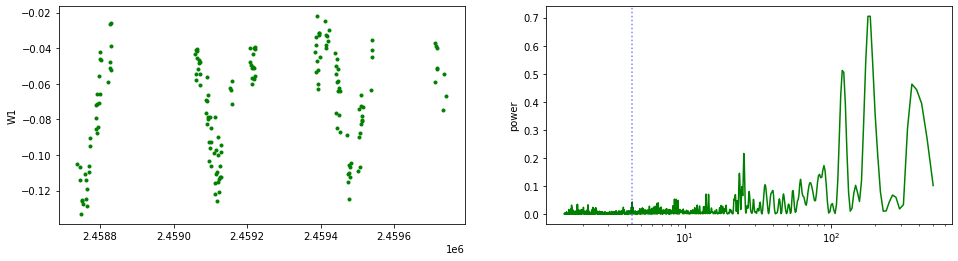

In [5]:
pca = PCA(n_components=Data.shape[1])
pca.fit(Data)

fig, ax = plt.subplots(1, 2, sharex='col', figsize=(16,4))

ax[0].plot(time_grid, pca.components_[0], 'g.')
ax[0].set_ylabel('W1')

frequency, power = LombScargle(time_grid, pca.components_[0]).autopower(minimum_frequency=1/500, maximum_frequency=1/1.5)
ax[1].plot(1/frequency, power, 'g')
ax[1].set_ylabel("power")
ax[1].set_xscale('log')
ax[1].axvline(Prot, linestyle=':', color='b', alpha=0.5)

plt.show()

one see clearly the domination of the telluric spikes in W1 


now lets filter it out

# SPCAndie

In [6]:
def periodo(ind, X, t, freq_grid, show = False):
    # This function turn time domain data into periodograms while recording it's maximum frequency
    t, dlw  = popnan(ind, X, t)
    ls = LombScargle(t, dlw)
    power = ls.power(freq_grid)
    max_freq = freq_grid[np.argmax(power)]
    return(power, 1/max_freq)

def popnan(ind, X, t):
    # Was implemented to handle data with NaNs in it but in fact not needed here
    Xout = X[ind, np.invert(np.isnan(X[ind]))]
    tout = t[np.invert(np.isnan(X[ind]))]
    return(tout, Xout)

def PacMapDisp(X, n_neighbors=10, MN_rate=0.5, FP_rate=2.0):
    # Clustering algorithm
    random.seed(110)
    X = X.reshape(X.shape[0], -1)
    # Initialize the pacmap instance
    # Setting n_neighbors to "None" leads to an automatic parameter selection
    # choice shown in "parameter" section of the README file.
    # Notice that from v0.6.0 on, we rename the n_dims parameter to n_components.
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=n_neighbors, MN_ratio=MN_rate, FP_ratio=FP_rate, random_state = 110, apply_pca = True)
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(X, init="pca")
    # visualize the embedding
    fig = plt.figure()
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="nipy_spectral", c=mf, s=2, norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.title('PacMap')
    plt.show()
    return(X_transformed)

100%|██████████| 15000/15000 [01:20<00:00, 185.21it/s]
/home/paul/.local/lib/python3.8/site-packages/pacmap/pacmap.py:774: UserWarning: Warning: random state is set to 110
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


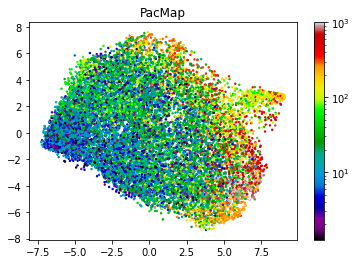

In [7]:
# Record every periodograms
powers = []
mf = []
for i in tqdm(range(Data.shape[0])):
    p, m = periodo(i, Data, time_grid, new_freq) 
    powers.append(p)
    mf.append(m)
powers = np.array(powers)
mf = np.array(mf)

# Run clustering
PacMap_map = PacMapDisp(powers)

(429, 2)
(602, 2)


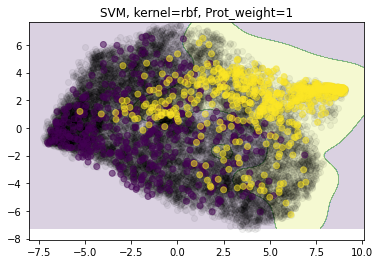

In [8]:
## Pre-attribute lines to activity or telluric class
def select_per(Per, mxfq):
    U = Per * 0.05
    indlw = []
    for i in range(len(mxfq)):
        if mxfq[i]>Per-U and mxfq[i]<Per+U:
            indlw.append(i)
    return(indlw)

Pac_an_1  = PacMap_map[select_per(an, mf)]
Pac_an_2  = PacMap_map[select_per(an/2, mf)]
Pac_an_3  = PacMap_map[select_per(an/3, mf)]
Pac_prot_1  = PacMap_map[select_per(Prot, mf)]
Pac_prot_2  = PacMap_map[select_per(Prot/2, mf)]

Pac_prot = np.concatenate((Pac_prot_1, Pac_prot_2))
Pac_an   = np.concatenate((Pac_an_1, Pac_an_2, Pac_an_3))
print(Pac_prot.shape)
print(Pac_an.shape)
color_identification = np.concatenate((np.zeros_like(Pac_prot.T[0]), np.ones_like(Pac_an.T[0])))
Pac_split = np.concatenate((Pac_prot, Pac_an))

## Run SVM
SVM_model = svm.SVC(kernel='rbf', gamma='auto', class_weight={0:1, 1:1})
SVM_model = SVM_model.fit(Pac_split, color_identification)

disp = DecisionBoundaryDisplay.from_estimator(SVM_model, Pac_split, response_method = 'predict', alpha = 0.2, grid_resolution=1000)
plt.scatter(PacMap_map[:,0], PacMap_map[:,1], c='k', alpha = 0.05)
plt.scatter(Pac_split[:,0], Pac_split[:, 1], c=color_identification, alpha=0.5)
plt.title('SVM, kernel=rbf, Prot_weight=1')
plt.show()

## Attribute a class for every lines

predicted_class = SVM_model.predict(PacMap_map)

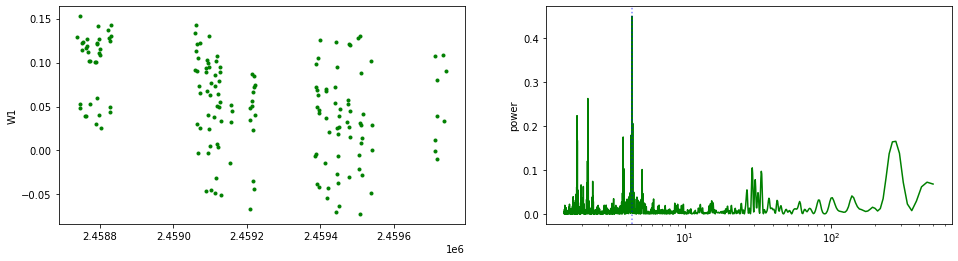

In [9]:
## Select only activity class data
data_filtr  = Data[predicted_class == 0]

## Compute PCA on it 
pca_filtr = PCA(n_components=data_filtr.shape[1])
pca_filtr.fit(data_filtr)

fig, ax = plt.subplots(1, 2, figsize=(16,4))

ax[0].plot(time_grid, pca_filtr.components_[0], 'g.')
ax[0].set_ylabel('W1')

frequency, power = LombScargle(time_grid, pca_filtr.components_[0]).autopower(minimum_frequency=1/500, maximum_frequency=1/1.5)
ax[1].plot(1/frequency, power, 'g')
ax[1].set_ylabel("power")
ax[1].set_xscale('log')
ax[1].axvline(Prot, linestyle=':', color='b', alpha=0.5)

plt.show()

Here is finally only the activity, Good job ! 